In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [4]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI images/Training/'
test_dir = '/content/drive/MyDrive/MRI images/Testing/'

In [5]:
# load and shuffle the train data
train_paths=[]
train_labels=[]
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths,train_labels=shuffle(train_paths, train_labels)

# load and shuffle the test data
test_paths=[]
test_labels=[]
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)
train_paths


['/content/drive/MyDrive/MRI images/Training/pituitary/Tr-pi_0953.jpg',
 '/content/drive/MyDrive/MRI images/Training/glioma/Tr-gl_0705.jpg',
 '/content/drive/MyDrive/MRI images/Training/notumor/Tr-no_0660.jpg',
 '/content/drive/MyDrive/MRI images/Training/notumor/Tr-no_1120.jpg',
 '/content/drive/MyDrive/MRI images/Training/glioma/Tr-gl_1211.jpg',
 '/content/drive/MyDrive/MRI images/Training/pituitary/Tr-pi_0086.jpg',
 '/content/drive/MyDrive/MRI images/Training/meningioma/Tr-me_0889.jpg',
 '/content/drive/MyDrive/MRI images/Training/meningioma/Tr-me_0201.jpg',
 '/content/drive/MyDrive/MRI images/Training/notumor/Tr-no_0626.jpg',
 '/content/drive/MyDrive/MRI images/Training/glioma/Tr-gl_0910.jpg',
 '/content/drive/MyDrive/MRI images/Training/notumor/Tr-no_0684.jpg',
 '/content/drive/MyDrive/MRI images/Training/pituitary/Tr-pi_1436.jpg',
 '/content/drive/MyDrive/MRI images/Training/pituitary/Tr-pi_1237.jpg',
 '/content/drive/MyDrive/MRI images/Training/glioma/Tr-gl_0629.jpg',
 '/content

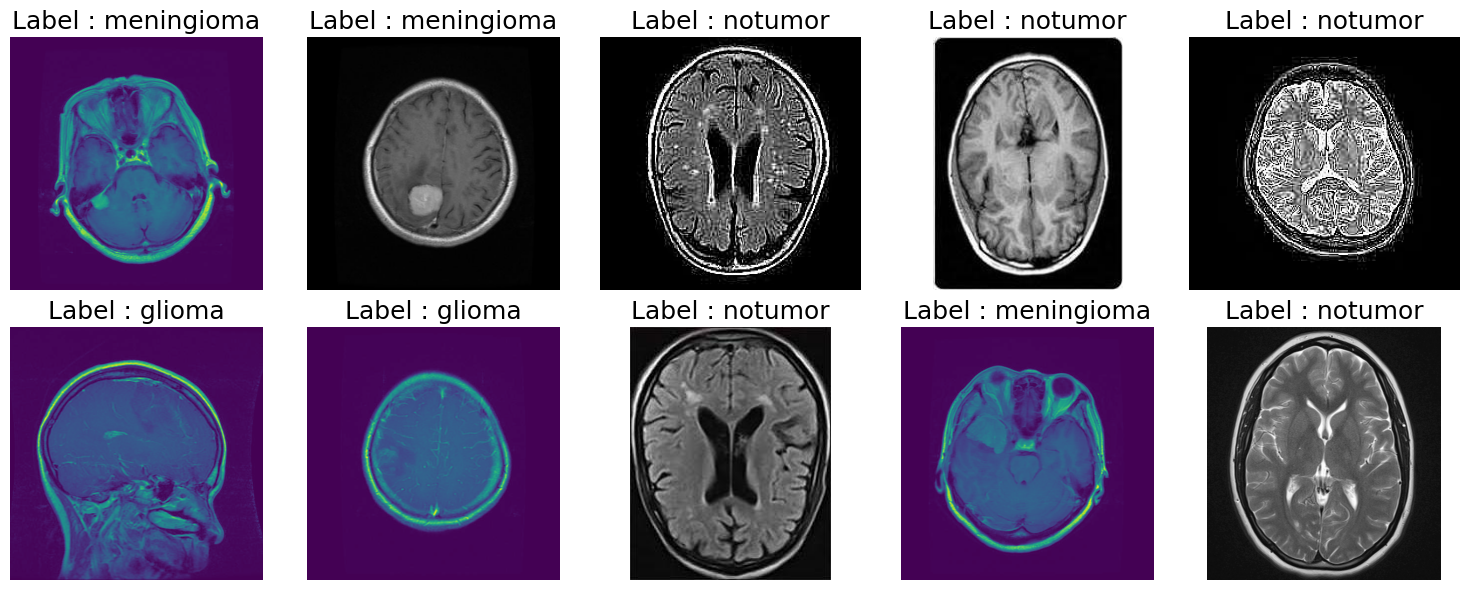

In [6]:
# Data Visualization
import random
import matplotlib.pyplot as plt

# select random indices
random_indices = random.sample(range(len(train_paths)),10)

# create a figure to display images in 2 rows
fig, axes= plt.subplots(2,5, figsize=(15,6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
  img_path=train_paths[idx]
  img=Image.open(img_path)

  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f"Label : {train_labels[idx]}", fontsize=18)

plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# model architecture
IMAGE_SIZE= 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), include_top=False, weights='imagenet')

# freeze all layers of the VGG16 base model
for layer in base_model.layers:
  layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# build model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))   # input layer
model.add(base_model)     # VGG16 model
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# parameters
batch_size = 20
steps= int(len(train_paths)/batch_size)
epochs= 5

# train model
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,  # misalnya '/content/dataset/Training'
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 4571 images belonging to 4 classes.
Found 1142 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 3380s 15s/step - loss: 0.5332 - sparse_categorical_accuracy: 0.7952 - val_loss: 0.7618 - val_sparse_categorical_accuracy: 0.7618
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - loss: 0.1977 - sparse_categorical_accuracy: 0.9298 - val_loss: 0.4520 - val_sparse_categorical_accuracy: 0.8415
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - loss: 0.1123 - sparse_categorical_accuracy: 0.9564 - val_loss: 0.4901 - val_sparse_categorical_accuracy: 0.8398
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - loss: 0.0748 - sparse_categorical_accuracy: 0.9734 - val_loss: 0.6664 - val_sparse_categorical_accuracy: 0.8424
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 27s 120ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.5121 - val_sparse_categorical_accuracy: 0.8634


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# lalu tambahkan ke model.fit()
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # boleh lebih karena akan berhenti otomatis
    callbacks=[early_stop]
)


Epoch 1/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 30s 130ms/step - loss: 0.0344 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.5840 - val_sparse_categorical_accuracy: 0.8651
Epoch 2/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 29s 128ms/step - loss: 0.0282 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.6044 - val_sparse_categorical_accuracy: 0.8651
Epoch 3/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - loss: 0.0219 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.6497 - val_sparse_categorical_accuracy: 0.8660


In [1]:
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameter
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 5
TRAIN_DIR = '/content/drive/MyDrive/MRI images/Training/'  # sesuaikan path dataset training kamu

# Load base model VGG16 tanpa top layer, dengan bobot imagenet
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze semua layer base model dulu
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze beberapa layer atas (misal 3 layer terakhir)
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Bangun model akhir
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(len(os.listdir(TRAIN_DIR)), activation='softmax')  # jumlah kelas otomatis
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Buat ImageDataGenerator dengan augmentasi dan split validasi
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

# Load data training
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# Load data validasi
val_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

# Mulai training dengan opsi workers untuk percepat data loading
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)



Found 4571 images belonging to 4 classes.
Found 1142 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 469ms/step - loss: 0.6852 - sparse_categorical_accuracy: 0.7085 - val_loss: 0.5981 - val_sparse_categorical_accuracy: 0.7776
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 360ms/step - loss: 0.2963 - sparse_categorical_accuracy: 0.8928 - val_loss: 0.5109 - val_sparse_categorical_accuracy: 0.8091
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 370ms/step - loss: 0.2202 - sparse_categorical_accuracy: 0.9227 - val_loss: 0.4095 - val_sparse_categorical_accuracy: 0.8529
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 361ms/step - loss: 0.1727 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.4819 - val_sparse_categorical_accuracy: 0.8406
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 358ms/step - loss: 0.1625 - sparse_categorical_accuracy: 0.9376 - val_loss: 0.4361 - val_sparse_categorical_accuracy: 0.8529


In [25]:
model.save('model.h5')

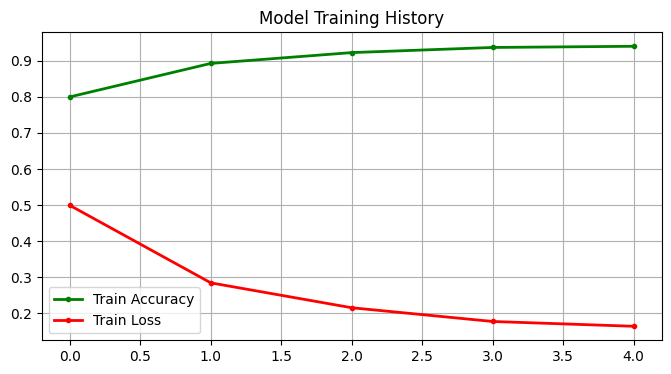

In [3]:
import matplotlib.pyplot as plt  # pastikan sudah import

plt.figure(figsize=(8,4))   # figsize harus tuple (lebar, tinggi)
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2, label='Train Accuracy')
plt.plot(history.history['loss'], '.r-', linewidth=2, label='Train Loss')
plt.title('Model Training History')
plt.legend()
plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/MRI images/Testing/',
    target_size=(128, 128),
    batch_size=20,
    class_mode='sparse',
    shuffle=False
)

test_labels = test_generator.classes  # array of integer labels


Found 1311 images belonging to 4 classes.


In [9]:
import os

test_dir = '/content/drive/MyDrive/MRI images/Testing/'  # ganti dengan path folder test kamu

test_paths = []
test_labels = []

for label_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, label_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            test_paths.append(img_path)
            test_labels.append(label_name)

print(f"Found {len(test_paths)} test images belonging to {len(set(test_labels))} classes.")

Found 1311 test images belonging to 4 classes.


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.86      0.90       300
  meningioma       0.84      0.86      0.85       306
     notumor       0.97      0.95      0.96       405
   pituitary       0.89      0.97      0.93       300

    accuracy                           0.91      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.91      0.91      0.91      1311



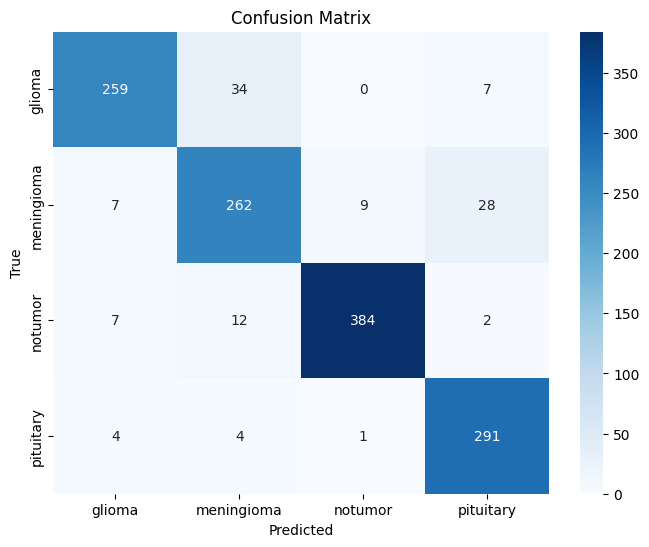

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix




# Encode label ke angka
le = LabelEncoder()
test_labels_encoded = le.fit_transform(test_labels)

# Load test images
test_images = open_images(test_paths, image_size=128)

# Predict
test_predictions = model.predict(test_images)
predicted_classes = np.argmax(test_predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, predicted_classes, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels_encoded, predicted_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


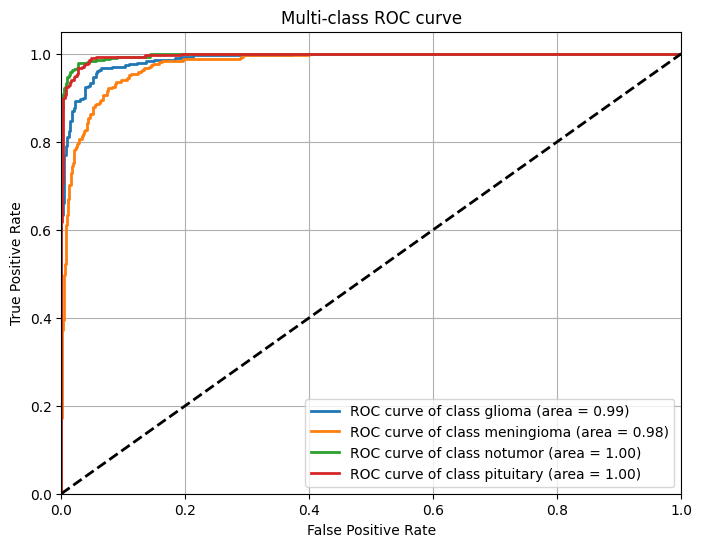

In [20]:
# ROC Curve Plot
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
n_classes = len(class_names)

y_test_bin = label_binarize(test_labels_encoded, classes=range(n_classes))
y_score = model.predict(test_images)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [26]:
model.save('model.h5')

In [27]:
!ls


drive  mode.h5	model.h5  my_model.keras  sample_data


In [30]:
model.save('my_model.keras')

In [31]:
from google.colab import files
files.download('/content/model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>